In [1]:
# import statements
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy 

In [2]:
model = models.resnet50(pretrained=True)

# print(model)
for param in model.parameters():
    param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
for param in model.layer4.parameters():
    param.requires_grad = True
    
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(p=0.4),
                         nn.Linear(512,256),
                         nn.ReLU(),
                         nn.Dropout(p=0.4),
                         nn.Linear(256,3),
                         nn.LogSoftmax(dim=1))

# print(model)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [3]:
model = model.to(torch.device("cuda"))

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Classification\threecato'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(dataloaders['train'])

cuda:0


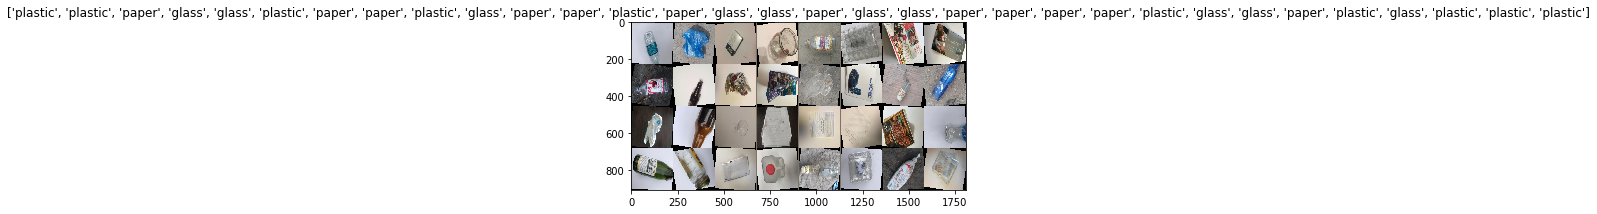

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
loss_array = {'train': [],
              'val' : []}
acc_array = {'train': [],
              'val' : []}

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_array[phase].append(epoch_loss)
            acc_array[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 4, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# model = train_model(model, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0864 Acc: 0.3995
val Loss: 1.0521 Acc: 0.6039

Epoch 1/24
----------
train Loss: 1.0220 Acc: 0.5676
val Loss: 0.9420 Acc: 0.7623

Epoch 2/24
----------
train Loss: 0.8516 Acc: 0.6989
val Loss: 0.6729 Acc: 0.7966

Epoch 3/24
----------
train Loss: 0.5979 Acc: 0.7746
val Loss: 0.4957 Acc: 0.8223

Epoch 4/24
----------
train Loss: 0.4527 Acc: 0.8184
val Loss: 0.3644 Acc: 0.8630

Epoch 5/24
----------
train Loss: 0.3489 Acc: 0.8568
val Loss: 0.3135 Acc: 0.8651

Epoch 6/24
----------
train Loss: 0.2787 Acc: 0.8989
val Loss: 0.2979 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.2816 Acc: 0.8957
val Loss: 0.2858 Acc: 0.8779

Epoch 8/24
----------
train Loss: 0.2616 Acc: 0.9016
val Loss: 0.2678 Acc: 0.8822

Epoch 9/24
----------
train Loss: 0.2593 Acc: 0.9032
val Loss: 0.2713 Acc: 0.8779

Epoch 10/24
----------
train Loss: 0.2517 Acc: 0.9059
val Loss: 0.2659 Acc: 0.8887

Epoch 11/24
----------
train Loss: 0.2291 Acc: 0.9205
val Loss: 0.2553 Acc: 0.8951

Ep

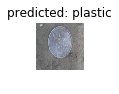

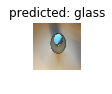

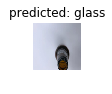

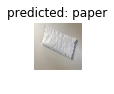

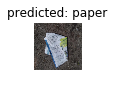

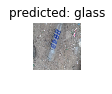

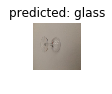

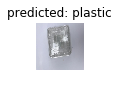

In [9]:
visualize_model(model)

plt.ioff()
plt.show()

In [6]:
model.load_state_dict(torch.load('final-res50.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [1]:
from torch.autograd import Variable
from PIL import Image
imsize = 224
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

image = image_loader('singleImg/c.jpg')
np_image = image.detach()
np_image = np.squeeze(np_image)
# print(np_image.shape)
# print(image.shape)
imshow(np_image)
# model_conv(image)


#passing image to model for classification
y_pred = model(image.cuda())
print(y_pred)
_, preds = torch.max(y_pred, 1)
print('Prediction is:{}'.format(class_names[preds])) 

NameError: name 'transforms' is not defined

In [11]:
# torch.save(model.state_dict(),'final-res50.pth')


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
# print("Confusion matrix: \ntrue value(Horizontal) vs predicted value(Vertical)")
# print(confusion_matrix)

In [14]:
conf_np = confusion_matrix.numpy()
probab_confuse = conf_np/conf_np.sum(axis=1)[:,None]
print('pred_glass pred_paper pred_plastic')
print('================================================')
print(np.around((probab_confuse * 100),decimals=1))

print('\n\n')
print('class based accuracy:')
print('=======================')
individual = confusion_matrix.diag()/confusion_matrix.sum(1)
print("glass:   ",individual[0])
print("paper:   ",individual[1])
print("plastic: ",individual[2])

pred_glass pred_paper pred_plastic
[[91.8  0.   8.2]
 [ 0.6 94.2  5.2]
 [10.6  5.6 83.9]]



class based accuracy:
glass:    tensor(0.9179)
paper:    tensor(0.9419)
plastic:  tensor(0.8385)


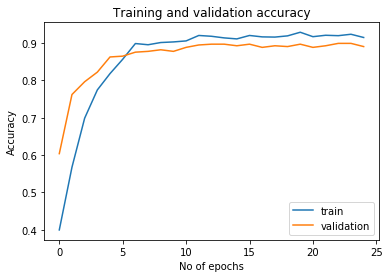

In [15]:
x = np.arange(25)
plt.title('Training and validation accuracy')
plt.xlabel("No of epochs")
plt.ylabel("Accuracy")

plt.plot(x, acc_array['train'])
plt.plot(x, acc_array['val'])
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')

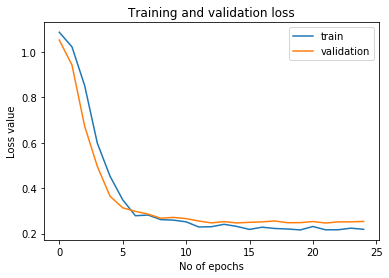

In [16]:
x = np.arange(25)
plt.title('Training and validation loss')
plt.xlabel("No of epochs")
plt.ylabel("Loss value")

plt.plot(x, loss_array['train'])
plt.plot(x, loss_array['val'])
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')

In [54]:
def custom_viz(kernels, path=None, cols=None, size=None, verbose=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    
    if verbose:
        print("Shape of input: ", kernels.shape)
    # If single channel kernel with HxW size,
    # plot them in a row.
    # Else, plot image with C number of columns.
    if cols==None:
        req_cols = C
    elif cols:
        req_cols = cols
    elif C>1:
        req_cols = C
    
    total_cols = N*C
    req_cols = cols
    num_rows = int(np.ceil(total_cols/req_cols))
    pos = range(1,total_cols + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()


In [62]:
kernels = model.conv4.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, 'conv1_weights.png', 4)


AttributeError: 'ResNet' object has no attribute 'conv4'

In [ ]:
plt.imshow()